In [2]:
!pip install openqaoa

  Using cached openqaoa-0.2.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached openqaoa_braket-0.2.6-py3-none-any.whl.metadata (4.6 kB)
  Using cached openqaoa_core-0.2.6-py3-none-any.whl.metadata (8.0 kB)
  Using cached openqaoa_qiskit-0.2.6-py3-none-any.whl.metadata (4.8 kB)
  Using cached openqaoa_azure-0.2.6-py3-none-any.whl.metadata (4.7 kB)
  Using cached qdk-0.29.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached qiskit_qir-0.5.0-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached azure_quantum-2.3.0-py3-none-any.whl.metadata (7.4 kB)
  Using cached numpy-1.26.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached docplex-2.25.236-py3-none-any.whl
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached qiskit-0.46.3-py3-none-any.whl.metadata (12 kB)
  Using cached qiskit_ibm_provider-0.11.0-py3-none-any.whl.metadata (7.6 kB)
  Using cac

In [3]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

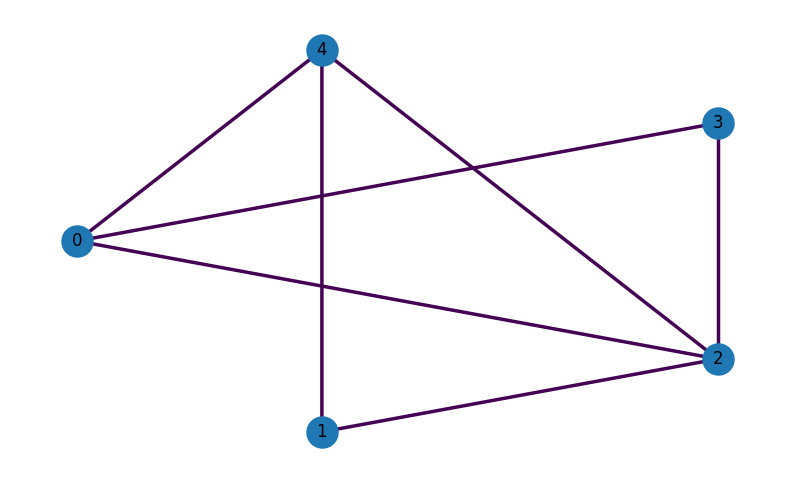

In [4]:
nodes = 5
edge_probability = 0.5
g = nx.generators.fast_gnp_random_graph(nodes, edge_probability, seed=30)

from openqaoa.utilities import plot_graph
plot_graph(g)

In [14]:
maxcut_prob = MaximumCut(g)

maxcut_qubo = maxcut_prob.qubo

In [18]:
hamiltonian = maxcut_qubo.hamiltonian
hamiltonian

In [19]:
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -3.0, Solution: ['11000', '10100', '11100', '11010', '00101', '00011', '01011', '00111']


In [20]:
# initialize model with statevector_simulator
q_sv = QAOA()

# device
qiskit_sv = create_device(location='local', name='qiskit.statevector_simulator')
q_sv.set_device(qiskit_sv)

# circuit properties
q_sv.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# classical optimizer properties
q_sv.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                             cost_progress=True, parameter_log=True)

q_sv.compile(maxcut_qubo)

In [21]:
# initialize model with shot-based simulator
q_shot = QAOA()

# device
qiskit_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_shot.set_device(qiskit_shot)

# circuit properties
q_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_shot.set_backend_properties(n_shots = 200)

# classical optimizer properties
q_shot.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                               cost_progress=True, parameter_log=True)

q_shot.compile(maxcut_qubo)

In [46]:
from qiskit import Aer
from qiskit.test.mock import FakeVigo
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator
device_backend = FakeVigo()
device = QasmSimulator.from_backend(device_backend)
noise_model = NoiseModel.from_backend(device)

/tmp/ipykernel_1809776/3184544667.py:2: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed in Qiskit 1.0. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo
/tmp/ipykernel_1809776/3184544667.py:5: DeprecationWarning: All fake backend instances based on real device snapshots (`FakeVigo`,`FakeSherbrooke`,...) have been migrated to the `qiskit_ibm_runtime` package. These classes are deprecated as of qiskit 0.46.0 and will be removed in qiskit 1.0.0. To migrate your code, run `pip install qiskit-ibm-runtime` and use `from qiskit_ibm_runtime.fake_provider import FakeExample` instead of `from qiskit.providers.fake_provider import FakeExample`. If you are using a custom fake backend implementation, you don't need to take any action.
  device_backend = FakeVigo()


In [29]:
# initialize model with noisy shot-based simulator
q_noisy_shot = QAOA()

# device

qiskit_noisy_shot = create_device(location='local', name='qiskit.qasm_simulator')
q_noisy_shot.set_device(qiskit_noisy_shot)

# circuit properties
q_noisy_shot.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties
q_noisy_shot.set_backend_properties(n_shots = 200, noise_model = noise_model)

# classical optimizer properties
q_noisy_shot.set_classical_optimizer(method='COBYLA', maxiter=200, tol=0.001,
                                     cost_progress=True, parameter_log=True)

q_noisy_shot.compile(maxcut_qubo)

In [30]:
q_sv.optimize()
q_shot.optimize()
q_noisy_shot.optimize()

In [31]:
results_sv = q_sv.result
results_shot = q_shot.result
results_noisy_shot = q_noisy_shot.result

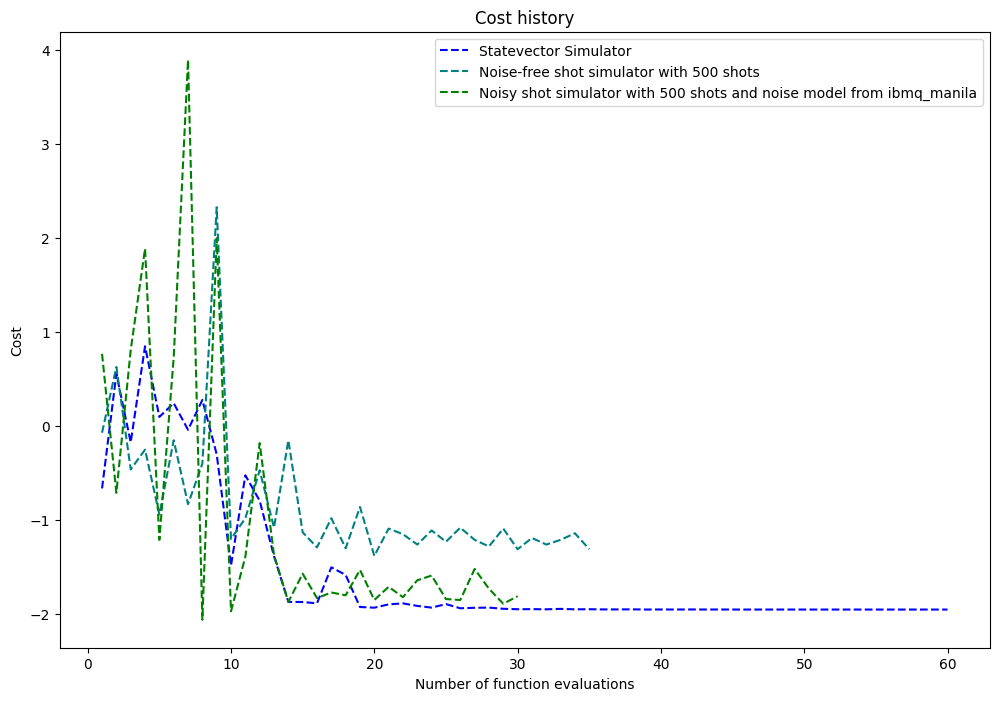

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,8))

fig, ax = results_sv.plot_cost(ax=ax,label='Statevector Simulator')
fig, ax = results_shot.plot_cost(ax=ax,color='teal', label='Noise-free shot simulator with 500 shots')
fig, ax = results_noisy_shot.plot_cost(ax=ax,color='green', label='Noisy shot simulator with 500 shots and noise model from ibmq_manila')

In [33]:
#import problem classes from OQ for easy problem creation
from openqaoa.problems import NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

#Import IBMQ
from qiskit import IBMQ

In [34]:
# Find partition of a list of 7 numbers generated randomly
prob = NumberPartition.random_instance(n_numbers=7)
prob_qubo = prob.qubo

(<Figure size 1000x600 with 2 Axes>, <Axes: >)

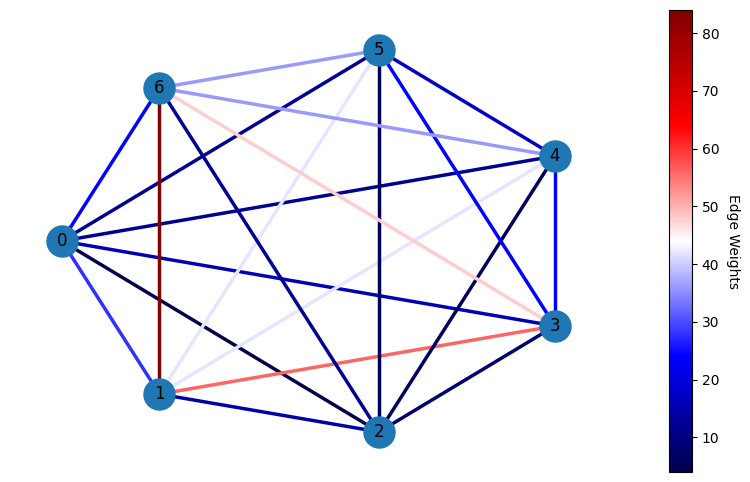

In [35]:
# visualize the QUBO form on a graph
from openqaoa.utilities import plot_graph, graph_from_hamiltonian

#extract Hamiltonain
cost_hamil = prob_qubo.hamiltonian

#convert Hamiltonian to graph
cost_gr = graph_from_hamiltonian(cost_hamil)

#plot the graph
plot_graph(cost_gr)

In [36]:
print(prob_qubo.asdict())

{'terms': [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [2, 3], [2, 4], [2, 5], [2, 6], [3, 4], [3, 5], [3, 6], [4, 5], [4, 6], [5, 6]], 'weights': [28.0, 4.0, 16.0, 12.0, 12.0, 24.0, 14.0, 56.0, 42.0, 42.0, 84.0, 8.0, 6.0, 6.0, 12.0, 24.0, 24.0, 48.0, 18.0, 36.0, 36.0], 'constant': 124, 'n': 7, 'problem_instance': {'problem_type': 'number_partition', 'numbers': [2, 7, 1, 4, 3, 3, 6], 'n_numbers': 7}, 'metadata': {}}


In [37]:
# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian

energy, configuration = ground_state_hamiltonian(cost_hamil)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 0.0, Solution: ['1101000', '1110100', '1110010', '0100110', '1011110', '0100001', '1011001', '0001101', '0001011', '0010111']


In [47]:
qpu_credentials ={
    "hub": "ibm-q",
    "group": "open",
    "project": "main"
}

In [48]:
# initialize model with default configurations
q_qiskit = QAOA()

In [49]:
# device. If qpu_crendetials is not specified,the default hub, group and provider is used.
qiskit_cloud = create_device(location='ibmq', name='ibm_brisbane', **qpu_credentials, as_emulator=True)
q_qiskit.set_device(qiskit_cloud)

# circuit properties
q_qiskit.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=20, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

In [50]:
q_qiskit.compile(prob_qubo)
# to use routing, pass your custom function as below
# q_qiskit.compile(prob_qubo, routing_function = my_custom_routing)

In [63]:
print(q_qiskit.backend.parametric_circuit.count_ops()["cx"])
q_qiskit.backend.parametric_circuit.draw()

42


┌───┐                                            »
q523_0: ┤ H ├──■─────────────────────────────────■────■──»
        ├───┤┌─┴─┐┌───────────────────────────┐┌─┴─┐  │  »
q523_1: ┤ H ├┤ X ├┤ Rz(TWOQ_COST_seq0_layer0) ├┤ X ├──┼──»
        ├───┤└───┘└───────────────────────────┘└───┘┌─┴─┐»
q523_2: ┤ H ├───────────────────────────────────────┤ X ├»
        ├───┤                                       └───┘»
q523_3: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_4: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_5: ┤ H ├────────────────────────────────────────────»
        ├───┤                                            »
q523_6: ┤ H ├────────────────────────────────────────────»
        └───┘                                            »
  c2: 7/═════════════════════════════════════════════════»
                                                         »
«                                                                            »
«q523_0: ───────────────────────────────■────■───────────────────────────────»
«                                       │    │                               »
«q523_1: ───────────────────────────────┼────┼────────────────■──────────────»
«        ┌───────────────────────────┐┌─┴─┐  │              ┌─┴─┐            »
«q523_2: ┤ Rz(TWOQ_COST_seq1_layer0) ├┤ X ├──┼──────────────┤ X ├────────────»
«        └───────────────────────────┘└───┘┌─┴─┐┌───────────┴───┴───────────┐»
«q523_3: ──────────────────────────────────┤ X ├┤ Rz(TWOQ_COST_seq2_layer0) ├»
«                                          └───┘└───────────────────────────┘»
«q523_4: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«q523_5: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«q523_6: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«  c2: 7/════════════════════════════════════════════════════════════════════»
«                                                                            »
«                                                    »
«q523_0: ───────────────────────────────■─────────■──»
«                                       │         │  »
«q523_1: ───────────────────────────────┼────■────┼──»
«        ┌───────────────────────────┐  │  ┌─┴─┐  │  »
«q523_2: ┤ Rz(TWOQ_COST_seq6_layer0) ├──┼──┤ X ├──┼──»
«        └───────────────────────────┘┌─┴─┐└───┘  │  »
«q523_3: ─────────────────────────────┤ X ├───────┼──»
«                                     └───┘     ┌─┴─┐»
«q523_4: ───────────────────────────────────────┤ X ├»
«                                               └───┘»
«q523_5: ────────────────────────────────────────────»
«                                                    »
«q523_6: ────────────────────────────────────────────»
«                                                    »
«  c2: 7/════════════════════════════════════════════»
«                                                    »
«                                                                            »
«q523_0: ────────────────────────────────────────────────────────────■───────»
«                                                                    │       »
«q523_1: ──────────────■─────────────────────────────────────────────┼────■──»
«                      │                                             │    │  »
«q523_2: ──────────────┼─────────────────────────────────────────────┼────┼──»
«                    ┌─┴─┐            ┌───────────────────────────┐  │  ┌─┴─┐»
«q523_3: ────────────┤ X ├────────────┤ Rz(TWOQ_COST_seq7_layer0) ├──┼──┤ X ├»
«        ┌───────────┴───┴───────────┐└───────────────────────────┘┌─┴─┐└───┘»
«q523_4: ┤ Rz(TW

In [64]:
q_qiskit.optimize()

ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_dynamic_circuits': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not load 'ibm_backend': No module named 'qiskit.primitives.containers'
ERROR:stevedore.extension:Could not l

In [ ]:
opt_results = q_qiskit.result


(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'Cost history'}, xlabel='Number of function evaluations', ylabel='Cost'>)

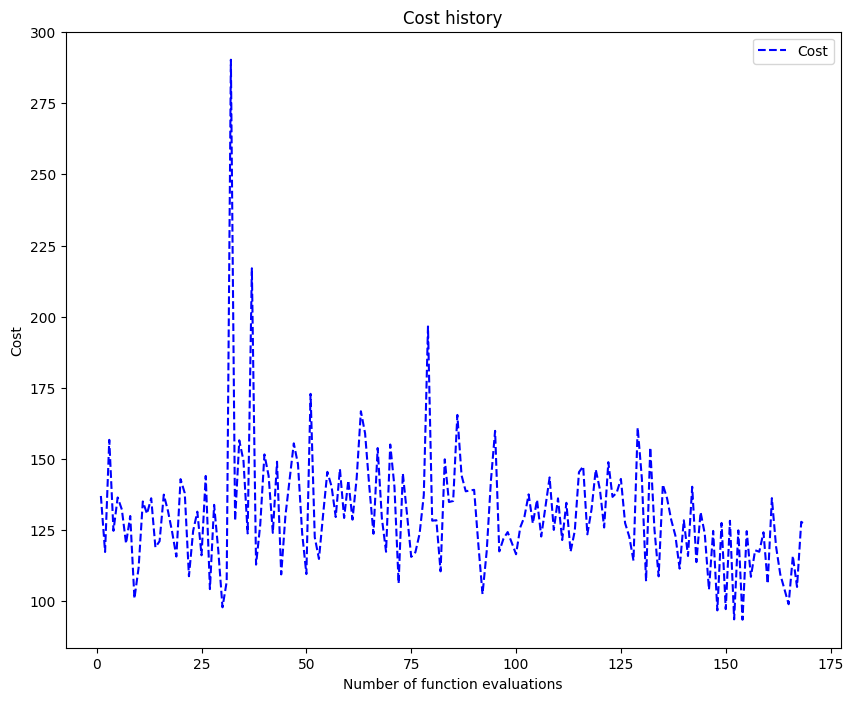

In [69]:
opt_results
opt_results.plot_cost()

In [54]:
rigetti_args ={
    'as_qvm':True,
    'execution_timeout':10,
    'compiler_timeout':100
}

In [ ]:
# initialize model with default configurations
q_pyquil = QAOA()

In [66]:
# device
# rigetti_device = create_device(location='qcs', name='Aspen-M-3', **rigetti_args)
rigetti_device = create_device(location='qcs', name='7q-qvm', **rigetti_args)

q_pyquil.set_device(rigetti_device)

# circuit properties
q_pyquil.set_circuit_properties(p=1, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_pyquil.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_pyquil.set_classical_optimizer(method='nelder-mead', maxiter=200, cost_progress=True,
                                 parameter_log=True, optimization_progress=True)

ValueError: Invalid device location, Choose from: dict_keys(['local', 'azure', 'ibmq', 'aws'])

In [83]:
# import the standard modules from python
import numpy as np
import matplotlib.pyplot as plt

# import the OpenQAOA Parameterisation classes manually: Manual Mode
from openqaoa.qaoa_components import (PauliOp, Hamiltonian, QAOADescriptor,
create_qaoa_variational_params, QAOAVariationalStandardParams, QAOAVariationalExtendedParams)

# import the other OpenQAOA modules required for this example
from openqaoa.utilities import X_mixer_hamiltonian

In [72]:
# Create a hamiltonian on 3 qubits with 2 coupling terms and 1 bias term
Term1 = PauliOp('ZZ', (0, 1))
Term2 = PauliOp('ZZ', (0, 2))
Term3 = PauliOp('Z', (0, ))

hamiltonian = Hamiltonian([Term1, Term2, Term3], [0.7, 1.2, -0.5], 0.0)
print("hamiltonian =", hamiltonian)

hamiltonian = 0.7*Z_{0}Z_{1} + 1.2*Z_{0}Z_{2} + -0.5*Z_{0} + 0.0


In [84]:
# Create Circuit Params Class
mixer_hamiltonian = X_mixer_hamiltonian(n_qubits = 3)
qaoa_descriptor = QAOADescriptor(cost_hamiltonian = hamiltonian, mixer_block = mixer_hamiltonian, p=1)

In [74]:
create_qaoa_variational_params(qaoa_descriptor, params_type='standard', init_type='rand')

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.85047248]
	gammas: [2.08170965]

In [75]:
create_qaoa_variational_params(qaoa_descriptor = qaoa_descriptor, params_type = 'extended', init_type = 'rand')

Extended Parameterisation:
	p: 1
Parameters:
	betas_singles: [[2.75101903 0.17818037 0.10032624]]
	betas_pairs: []
	gammas_singles: [[0.82457245]]
	gammas_pairs: [[1.56210487 0.97135806]]

In [76]:
create_qaoa_variational_params(qaoa_descriptor = qaoa_descriptor,
                               params_type = 'standard', init_type = 'custom',
                               variational_params_dict = {'betas': [0.1], 'gammas': [0.1]})

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.1]
	gammas: [0.1]

In [85]:
linear_ramp_time = 1
p = 2
# create evenly spaced timelayers at the centers of p intervals
dt = linear_ramp_time / p

# fill betas, gammas_singles and gammas_pairs
betas = np.linspace((dt / linear_ramp_time) * (linear_ramp_time * (1 - 0.5 / p)),
                    (dt / linear_ramp_time) * (linear_ramp_time * 0.5 / p), p)
gammas = betas[::-1]

In [86]:
p = 2
T = 1 # total time T of the annealing schedule
qaoa_descriptor = QAOADescriptor(hamiltonian, mixer_hamiltonian, p=2)
params = create_qaoa_variational_params(qaoa_descriptor = qaoa_descriptor,
                                        params_type = 'standard', init_type = 'ramp',
                                        linear_ramp_time = 1)
print(params)

Standard Parameterisation:
	p: 2
Variational Parameters:
	betas: [0.375 0.125]
	gammas: [0.125 0.375]



In [87]:
from openqaoa.qaoa_components.variational_parameters import qaoa_variational_params_converter

In [88]:
print(params)

Standard Parameterisation:
	p: 2
Variational Parameters:
	betas: [0.375 0.125]
	gammas: [0.125 0.375]



In [89]:
new_params = qaoa_variational_params_converter(target_params_type = 'extended',
                        current_params_obj = params)

In [90]:
print(new_params)

Extended Parameterisation:
	p: 2
Parameters:
	betas_singles: [[0.375 0.375 0.375], [0.125 0.125 0.125]]
	betas_pairs: []
	gammas_singles: [[0.125], [0.375]]
	gammas_pairs: [[0.125 0.125], [0.375 0.375]]



In [91]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MinimumVertexCover

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

In [92]:
# Use the MinimumVertexCover class to instantiate the problem.
mvc_prob = MinimumVertexCover.random_instance(n_nodes=6, edge_probability=0.9, seed=3456)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
mvc_qubo = mvc_prob.qubo

/global/homes/g/gzquse/.local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [93]:
hamiltonian = mvc_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: 5.0, Solution: ['111110', '111101', '111011', '110111', '101111', '011111']


In [98]:
q_annealing = QAOA()
p=6
q_annealing.set_circuit_properties(p=p, param_type='annealing', init_type='ramp')
q_annealing.set_classical_optimizer(maxiter=2000)
q_annealing.compile(mvc_qubo)

In [99]:
# run optimization
q_annealing.optimize()
print("Optimized cost with AnnealingParams:", q_annealing.result.optimized['cost'])

Optimized cost with AnnealingParams: 8.297044217486


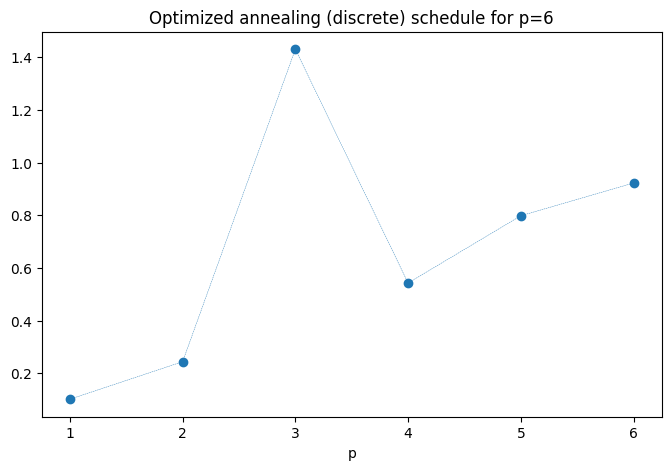

In [100]:
# annealing optimized schedule
opt_schedule = q_annealing.result.optimized['angles']
p_i = range(1,p+1)
fig = plt.figure(figsize=(8,5))
plt.plot(p_i,opt_schedule,lw=0.3,ls='--',marker='o')
plt.xlabel('p')
plt.title(f'Optimized annealing (discrete) schedule for p={p}');

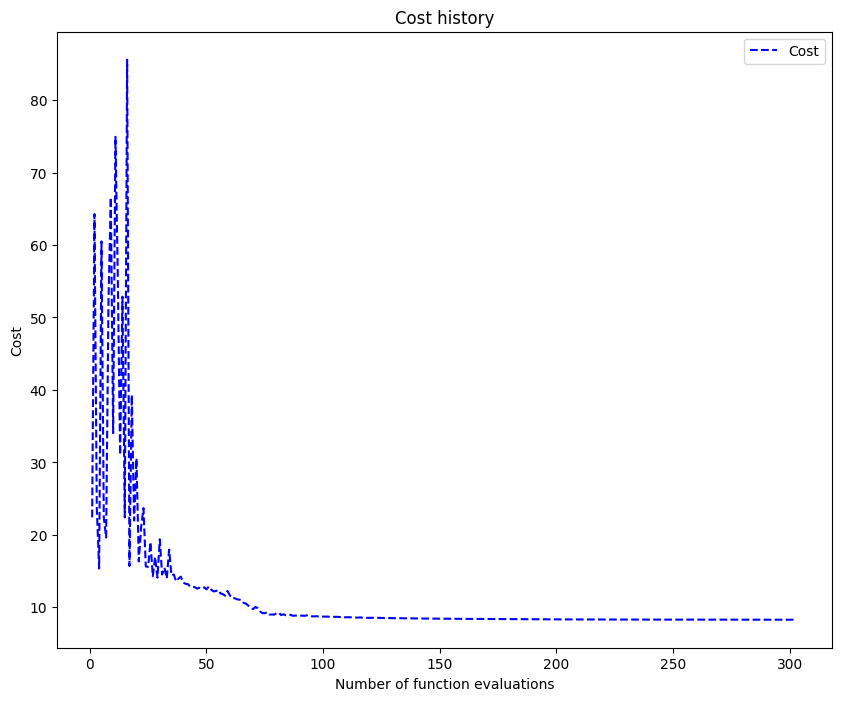

In [101]:
fig, ax = q_annealing.result.plot_cost()

In [116]:
q_std = QAOA()
p=6
q_std.set_circuit_properties(p=p, param_type='standard', init_type='ramp')
q_std.set_classical_optimizer(maxiter=200)
q_std.compile(mvc_qubo)

In [117]:
# run optimization
q_std.optimize()
print("Optimized cost with StandardParams:", q_std.result.optimized['cost'])

Optimized cost with StandardParams: 9.197959002011


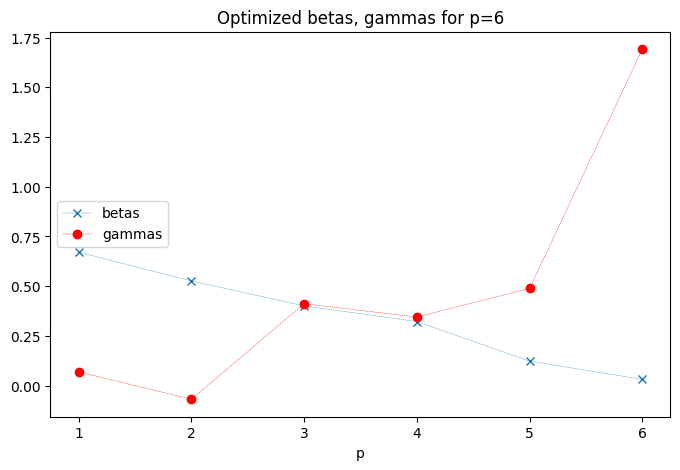

In [118]:
# annealing optimized schedule
opt_angles = q_std.result.optimized['angles']
opt_betas = opt_angles[:p]
opt_gammas = opt_angles[p:]
fig = plt.figure(figsize=(8,5))
plt.plot(p_i,opt_betas,lw=0.3,ls='--',marker='x',label='betas')
plt.plot(p_i,opt_gammas,lw=0.3,ls='--',marker='o',label='gammas',color='red')
plt.xlabel('p')
plt.legend(loc='center left')
plt.title(f'Optimized betas, gammas for p={p}');

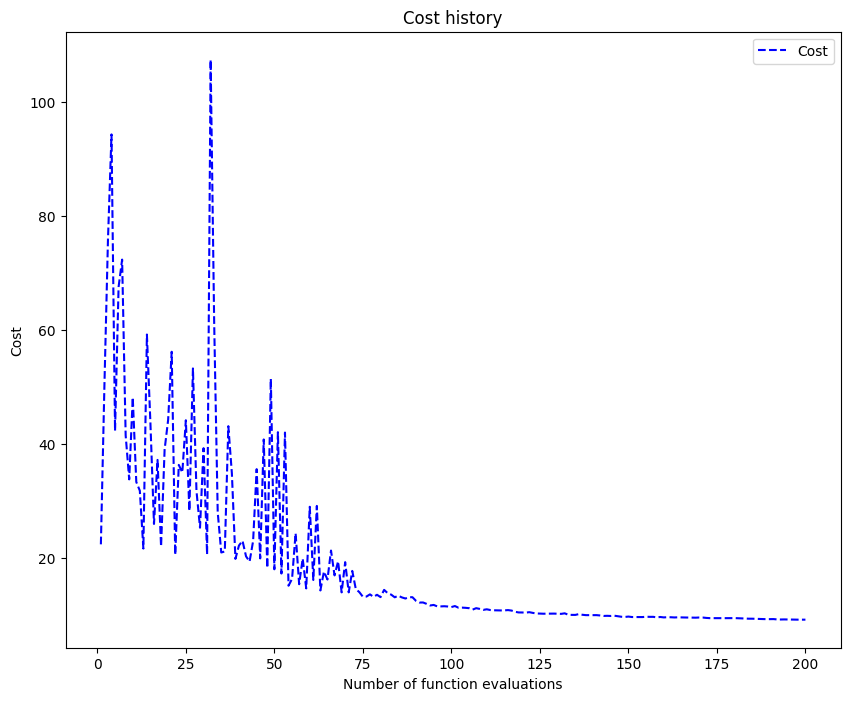

In [119]:
fig, ax = q_std.result.plot_cost()

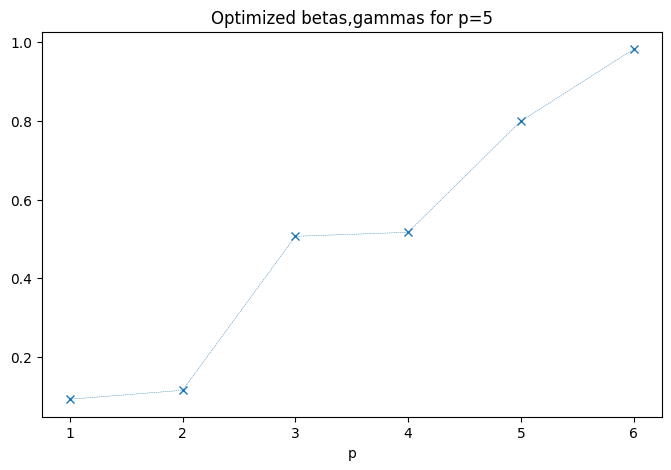

In [120]:
hybrid_params = [np.abs(opt_gammas[i])/(np.abs(opt_gammas[i]) + np.abs(opt_betas[i])) for i in range(p)]

fig = plt.figure(figsize=(8,5))
plt.plot(p_i,hybrid_params,lw=0.3,ls='--',marker='x',label='betas')
plt.xlabel('p')
plt.title('Optimized betas,gammas for p=5');

In [121]:
def compare_fourier_std_optimize(n_nodes, edge_probability, p_fourier, q, p_std):
    """
    Produce a random graph on the specified number of nodes, with edge_probability.
    Run the MinimumVertexCover problem on this graph and compare the optimization performance
    between the StandardParams and FourierParams

    Parameters
    ----------
    n_nodes: `int`
        The number of nodes in the graph
    edge_probability: `float`
        An edge_probability between nodes. Between 0 and 1.
    p_fourier: `int`
        Depth of QAOA circuit for Fourier parameterized circuits
    q: `int`
        Depth of fourier parameters of optimization
    p_std: `int`
        Depth of QAOA circuit for Standard parameterized circuits

    Return
    ------
    (minimized_cost_fourier, minimized_cost_std, exact_cost): `tuple`
    The optimal cost function values obtained by each method, as well as its exact minimum value
    (found by diagonalising the Hamiltonian).
    """
    mvc_random = MinimumVertexCover.random_instance(n_nodes=n_nodes,edge_probability=edge_probability)
    mvc_random_qubo = mvc_random.qubo

    q_std = QAOA()
    q_std.set_circuit_properties(p=p_std, param_type='standard', init_type='ramp', linear_ramp_time=0.7)
    q_std.set_classical_optimizer(maxiter=500)
    q_std.compile(mvc_qubo,verbose=False)
    q_std.optimize()

    q_fourier = QAOA()
    q_fourier.set_circuit_properties(p=p_fourier, param_type='fourier', init_type='ramp',q=q, linear_ramp_time=0.7)
    q_fourier.set_classical_optimizer(maxiter=500)
    q_fourier.compile(mvc_qubo,verbose=False)
    q_fourier.optimize()

    minimized_cost_std = q_std.result.optimized['cost']
    minimized_cost_fourier = q_fourier.result.optimized['cost']
    exact_cost = ground_state_hamiltonian(mvc_random_qubo.hamiltonian)[0]

    return (minimized_cost_fourier, minimized_cost_std, exact_cost)

In [122]:
p_fourier = 3
p_std = 2
q = 2

samples = 10

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):

    res_fourier, res_std, ground_energy = compare_fourier_std_optimize(6, 0.6, p_fourier, q, p_std);

    # Compute relative error
    err_fourier[i] = np.absolute((res_fourier - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std - ground_energy)/ground_energy)

print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  1.1716731408190002
Mean error using StandardParams:  2.1751659137103756


In [123]:
p_fourier = 3
p_std = 1
q = 1

samples = 10

err_fourier = np.zeros(samples)
err_std = np.zeros(samples)

for i in range(samples):

    res_fourier, res_std, ground_energy = compare_fourier_std_optimize(6, 0.6, p_fourier, q, p_std);

    # Compute relative error
    err_fourier[i] = np.absolute((res_fourier - ground_energy)/ground_energy)
    err_std[i] = np.absolute((res_std - ground_energy)/ground_energy)

print("Mean error using FourierParams: ", np.mean(err_fourier))
print("Mean error using StandardParams: ", np.mean(err_std))

Mean error using FourierParams:  0.97165530310085
Mean error using StandardParams:  8.28594016973695


In [124]:
p_fourier = 3
p_std = 1
q = 1

q_std = QAOA()
q_std.set_circuit_properties(p=p_std, param_type='standard', init_type='ramp')
q_std.set_classical_optimizer(maxiter=500)
q_std.compile(mvc_qubo,verbose=False)
q_std.optimize()

q_fourier = QAOA()
q_fourier.set_circuit_properties(p=p_fourier, param_type='fourier', init_type='ramp', q=q)
q_fourier.set_classical_optimizer(maxiter=500)
q_fourier.compile(mvc_qubo,verbose=False)
q_fourier.optimize()

Text(0.5, 1.0, 'Comparison of performance between Fourier and Standard Parameterizations')

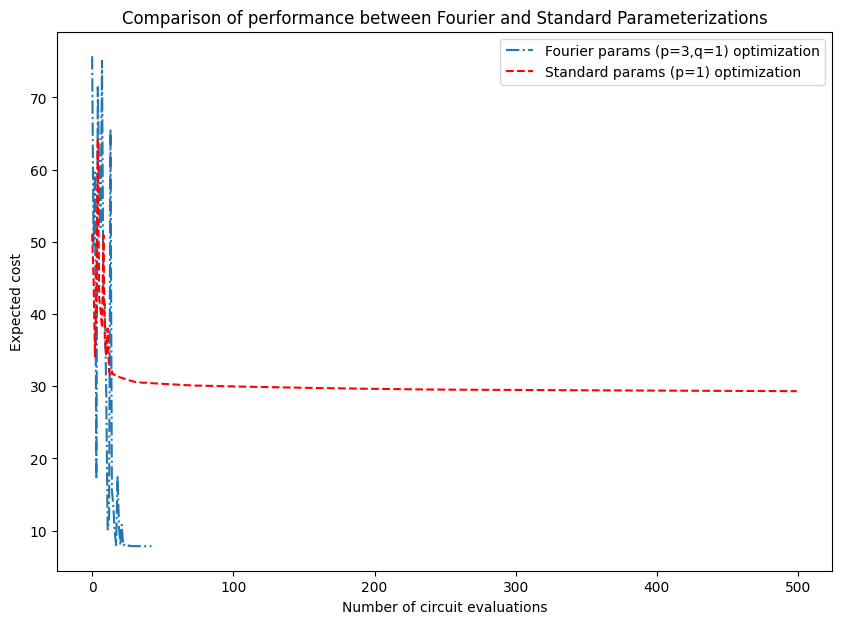

In [125]:
fig = plt.figure(figsize=(10,7))
plt.plot(q_fourier.result.intermediate['cost'],label='Fourier params (p=3,q=1) optimization',ls='-.')
plt.plot(q_std.result.intermediate['cost'],label='Standard params (p=1) optimization',ls='--',color='red')
plt.xlabel('Number of circuit evaluations')
plt.ylabel('Expected cost')
plt.legend()
plt.title('Comparison of performance between Fourier and Standard Parameterizations')

In [126]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

#importing the time module to record time for simulations
from time import time

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

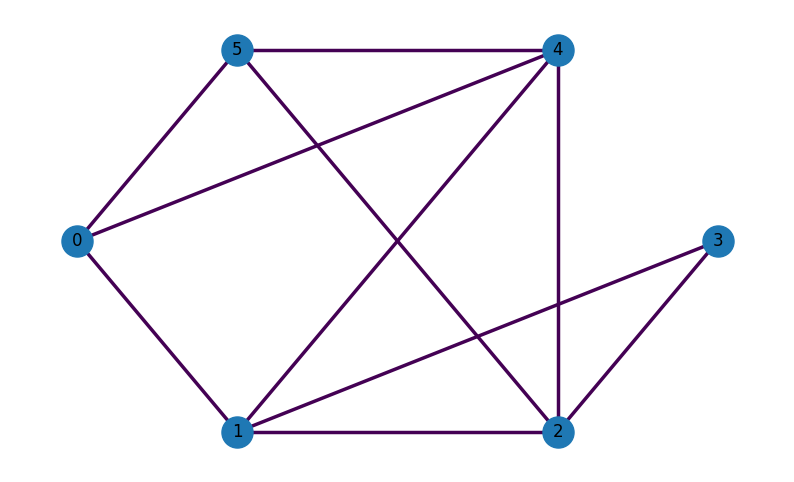

In [127]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability, seed=12)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)


In [128]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

In [129]:
pprint(maxcut_qubo.asdict())


{'constant': 0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 1},
                                      {'source': 0, 'target': 4},
                                      {'source': 0, 'target': 5},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 4},
                                      {'source': 2, 'target': 3},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
             

In [130]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -4.0, Solution: ['101000', '111000', '101100', '101010', '100110', '101110', '010001', '011001', '010101', '010011', '000111', '010111']


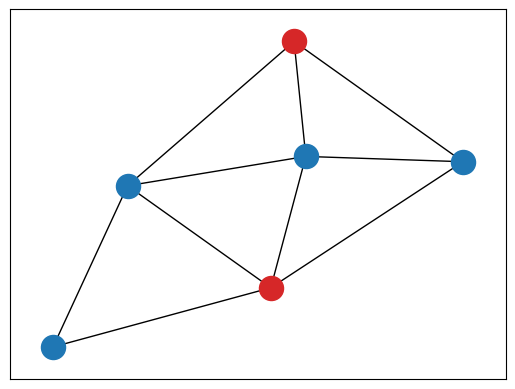

In [131]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In [132]:
q_qiskit_list = []
q_vector_list = []

for p in range(1,10):

    ## QAOA with Qiskit Simulator
    # initialize model with default configuration
    q_qiskit = QAOA()

    # optionally configure the following properties of the model

    # device
    qiskit_device = create_device(location='local', name='qiskit.statevector_simulator')
    q_qiskit.set_device(qiskit_device)

    # circuit properties
    q_qiskit.set_circuit_properties(p=p, param_type='standard', init_type='rand', mixer_hamiltonian='x', seed=12)

    # backend properties (already set by default)
    q_qiskit.set_backend_properties(prepend_state=None, append_state=None)

    # classical optimizer properties
    q_qiskit.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                                        optimization_progress=True, cost_progress=True, parameter_log=True)

    q_qiskit_list.append(q_qiskit)


    ## QAOA with Vectorized Simulator
    # initialize model with default configuration
    q_vector = QAOA()

    # optionally configure the following properties of the model

    # device
    vectorized_device = create_device(location='local', name='vectorized')
    q_vector.set_device(vectorized_device)

    # circuit properties
    q_vector.set_circuit_properties(p=p, param_type='standard', init_type='rand', mixer_hamiltonian='x', seed=12)

    # backend properties (already set by default)
    q_vector.set_backend_properties(prepend_state=None, append_state=None)

    # classical optimizer properties
    q_vector.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                            optimization_progress=True, cost_progress=True, parameter_log=True)

    q_vector_list.append(q_vector)


In [133]:
times_qiskit = []
times_vectorized = []

for q_qiskit, q_vector in zip(q_qiskit_list, q_vector_list):

    q_qiskit.compile(maxcut_qubo,verbose=False)
    q_vector.compile(maxcut_qubo,verbose=False)

    t1=time()
    q_qiskit.optimize()

    t2=time()

    q_vector.optimize()
    t3=time()

    times_qiskit.append(t2-t1)
    times_vectorized.append(t3-t2)

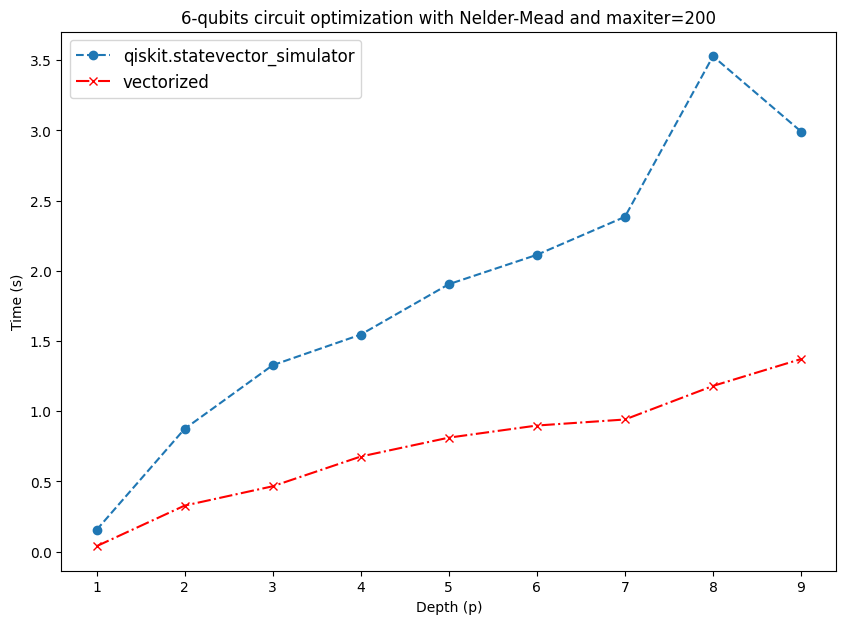

In [134]:
ps = range(1,10)
figure = plt.figure(figsize=(10,7))
plt.plot(ps, times_qiskit, ls = '--', marker = 'o', label='qiskit.statevector_simulator')
plt.plot(ps, times_vectorized, color='red', ls='-.', marker='x', label = 'vectorized')
plt.xlabel('Depth (p)')
plt.ylabel('Time (s)')
plt.title('6-qubits circuit optimization with Nelder-Mead and maxiter=200')
plt.legend(fontsize=12)

In [135]:
vector_opt_results = q_vector.result
qiskit_opt_results = q_qiskit.result

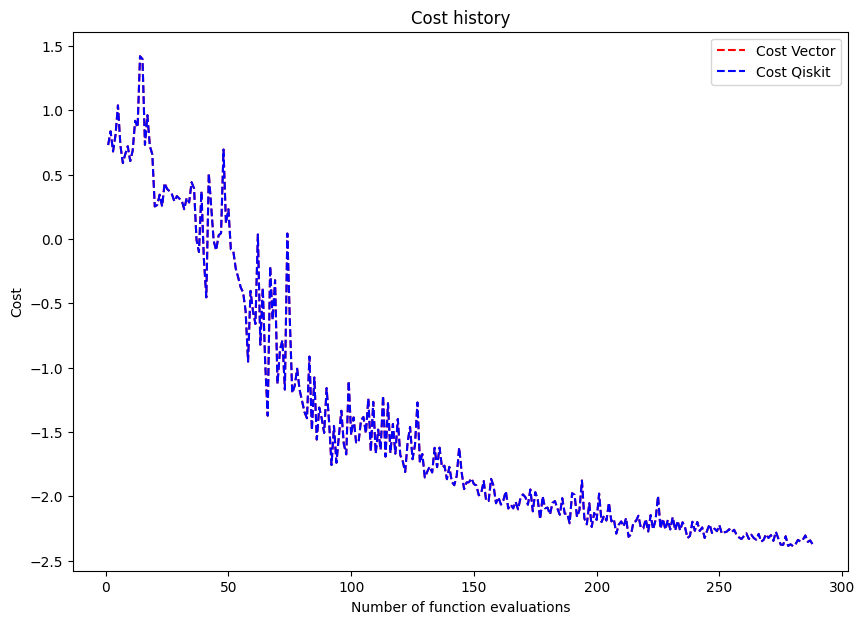

In [136]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
fig, ax = vector_opt_results.plot_cost(label='Cost Vector',color='red',ax=ax)
fig, ax = qiskit_opt_results.plot_cost(label='Cost Qiskit',color='blue',ax=ax)

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from openqaoa.qaoa_components import QAOADescriptor, create_qaoa_variational_params
from openqaoa.backends import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import random_classical_hamiltonian

In [138]:
cost_hamiltonian = random_classical_hamiltonian(range(7))
n_qubits = cost_hamiltonian.n_qubits
qubit_register = range(n_qubits)

In [139]:
# generate the mixer Hamiltonian
from openqaoa.qaoa_components import PauliOp, Hamiltonian
pauli_terms = [PauliOp('X',(i,)) for i in qubit_register]
pauli_coeffs = [1]*n_qubits
mixer_hamiltonian = Hamiltonian(pauli_terms,pauli_coeffs,constant=0)

# one could also simply just use a utility function to create the same mixer Hamiltonian as follows
# from openqaoa.utilities import X_mixer_hamiltonian
# mixer_hamiltonian = X_mixer_hamiltonian(n_qubits=3,pauli_coeffs)

In [140]:
qaoa_descriptor_p1 = QAOADescriptor(cost_hamiltonian, mixer_hamiltonian, p=1)
qaoa_descriptor_p2 = QAOADescriptor(cost_hamiltonian, mixer_hamiltonian, p=2)

In [142]:
variate_params_std = create_qaoa_variational_params(qaoa_descriptor_p1,'standard','ramp')
variate_params_fourier = create_qaoa_variational_params(qaoa_descriptor_p2,'fourier','ramp',q=1)

In [143]:
variate_params_std

Standard Parameterisation:
	p: 1
Variational Parameters:
	betas: [0.35]
	gammas: [0.35]

In [144]:
# call the device to use
device_qiskit = create_device(location = 'local', name = 'qiskit.qasm_simulator')

# initialize the backend with the device and circuit_params
backend_qiskit_p1 = get_qaoa_backend(qaoa_descriptor_p1, device_qiskit, n_shots = 500)
backend_qiskit_p2 = get_qaoa_backend(qaoa_descriptor_p2, device_qiskit, n_shots = 500)

In [145]:
# helper function to produce the cost landscape
def plot_cost_landscape(mixer_angle_iter, cost_angle_iter, variational_params, backend):
    """
    This function constructs a 2-D array containing cost values for different pairs
    of parameter values.

    Parameters
    ----------

    """
    cost_landscape = np.zeros((mixer_angle_iter.size,mixer_angle_iter.size),dtype=float)

    for i,mixer_angle in enumerate(mixer_angle_iter):
        for j,cost_angle in enumerate(cost_angle_iter):
            variational_params.update_from_raw([mixer_angle,cost_angle])
            cost_landscape[i,j] = backend.expectation(variational_params)

    return cost_landscape

In [146]:
# cost landscape for standard parameterization
gammas = np.linspace(-np.pi,np.pi,25)
betas = np.linspace(-np.pi/2,np.pi/2,25)

cost_landscape_std = plot_cost_landscape(betas, gammas, variate_params_std, backend_qiskit_p1)

# cost landscape for Fourier parameterization
us = np.linspace(0,2*np.pi,50)
vs = np.linspace(0,np.pi,50)

cost_landscape_fourier = plot_cost_landscape(vs, us, variate_params_fourier, backend_qiskit_p2)

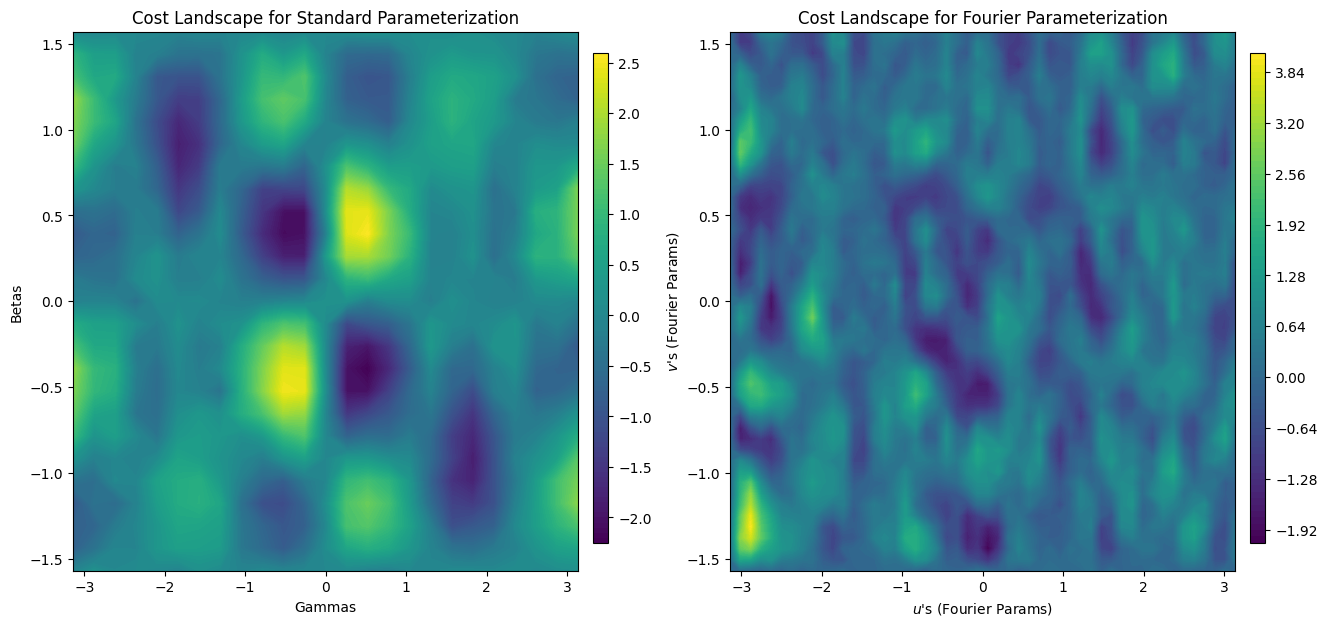

In [147]:
fig,axes = plt.subplots(1,2,sharex = False, sharey=False,figsize=(15,7),gridspec_kw={'wspace': 0.3})
cmap = 'viridis'

im_0 = axes[0].contourf(cost_landscape_std,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[0].set_title('Cost Landscape for Standard Parameterization')
axes[0].set_xlabel('Gammas')
axes[0].set_ylabel('Betas')

cbar_ax = fig.add_axes([0.472, 0.15, 0.01, 0.7])
fig.colorbar(im_0, cax=cbar_ax)

im_1 = axes[1].contourf(cost_landscape_fourier,cmap=cmap,levels=100,extent=(gammas[0],gammas[-1],betas[0],betas[-1]))
axes[1].set_title('Cost Landscape for Fourier Parameterization')
axes[1].set_xlabel("$u$'s (Fourier Params)")
axes[1].set_ylabel("$v$'s (Fourier Params)")

cbar_ax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
fig.colorbar(im_1, cax=cbar_ax)
plt.show()

In [154]:
import networkx as nx
import numpy as np
from openqaoa.problems import MinimumVertexCover, NumberPartition, Knapsack
import matplotlib.pyplot as plt
from pprint import pprint
from openqaoa.backends import create_device, DeviceLocal

In [155]:
kp_prob = Knapsack.random_instance(n_items=5, quantum=True,seed=1234)
kp_qubo = kp_prob.qubo
pprint(kp_qubo.asdict())

{'constant': 216.5,
 'metadata': {},
 'n': 9,
 'problem_instance': {'n_items': 5,
                      'penalty': 8,
                      'problem_type': 'knapsack',
                      'values': [4, 4, 4, 2, 1],
                      'weight_capacity': 13,
                      'weights': [4, 1, 2, 1, 2]},
 'terms': [[0, 1],
           [0, 2],
           [0, 3],
           [1, 2],
           [1, 3],
           [2, 3],
           [4, 5],
           [4, 6],
           [4, 7],
           [8, 4],
           [5, 6],
           [5, 7],
           [8, 5],
           [6, 7],
           [8, 6],
           [8, 7],
           [0, 4],
           [0, 5],
           [0, 6],
           [0, 7],
           [0, 8],
           [1, 4],
           [1, 5],
           [1, 6],
           [1, 7],
           [8, 1],
           [2, 4],
           [2, 5],
           [2, 6],
           [2, 7],
           [8, 2],
           [3, 4],
           [3, 5],
           [3, 6],
           [3, 7],
           [8, 3],
   

In [161]:
from openqaoa import QAOA
q = QAOA()
q.set_circuit_properties(p=3, init_type='ramp')
q.compile(kp_qubo)
q.optimize()

In [162]:
result = q.result
result.most_probable_states

{'solutions_bitstrings': ['000100000'], 'bitstring_energy': 200.0}

In [163]:
q_qiskit_sv = QAOA()
qiskit_dev = create_device(location='local',name='qiskit.statevector_simulator')
q_qiskit_sv.set_device(qiskit_dev)

In [164]:
q_qiskit_sv.compile(kp_qubo)
q_qiskit_sv.optimize()

In [165]:
qiskit_results = q_qiskit_sv.result
qiskit_results.most_probable_states

{'solutions_bitstrings': ['000110000'], 'bitstring_energy': 4.0}

In [166]:
qiskit_results.evals

{'number_of_evals': 29, 'jac_evals': 0, 'qfim_evals': 0}

In [167]:
qiskit_results.intermediate

{'angles': [[0.35, 0.35],
  [1.35, 0.35],
  [1.35, 1.35],
  [1.822370451816, -0.531400111329],
  [1.586185225908, -0.090700055665],
  [1.107374603994, 0.289726314092],
  [0.874986723481, 0.197553254086],
  [1.061288073991, 0.405920254349],
  [1.356749567622, 0.27205918316],
  [1.232062085808, 0.280892748626],
  [1.067097208615, 0.241935295883],
  [1.138417610573, 0.28613545869],
  [1.085761155786, 0.312296678656],
  [1.097653929758, 0.277493198488],
  [1.114323922504, 0.293295925906],
  [1.121078540299, 0.289370331086],
  [1.114212406068, 0.301107629967],
  [1.116886829692, 0.290347995138],
  [1.112660388281, 0.292272524149],
  [1.11071674546, 0.292080300711],
  [1.112904142973, 0.290334669429],
  [1.112590602338, 0.293246589977],
  [1.112725510973, 0.291788605133],
  [1.112902347789, 0.292305085495],
  [1.112850690299, 0.292790626515],
  [1.112940982498, 0.292064021179],
  [1.112895403108, 0.29240484406],
  [1.112952227072, 0.292308557835],
  [1.112967290836, 0.292209698931]],
 'cost'

In [168]:
qiskit_results.optimized


{'angles': [1.112952227072, 0.292308557835],
 'cost': 107.504668550891,
 'measurement_outcomes': array([-2.45038508e-02-1.31208386e-02j, -7.82037753e-03+2.95082418e-03j,
         2.32850424e-03+6.71403316e-03j,  6.51869564e-03+2.47645307e-03j,
         6.31419259e-04+2.15739573e-02j,  1.21970025e-02+3.06943569e-02j,
        -2.10600470e-02+2.54040035e-03j, -1.19348249e-02-1.79557096e-02j,
         3.60238581e-02+4.52349435e-03j,  1.96379191e-02+2.57784054e-02j,
        -3.29316639e-02+6.64535862e-03j, -2.52911156e-02-1.17057990e-02j,
         7.48297581e-02-5.36130483e-03j,  1.94147356e-02+1.13535257e-02j,
        -3.18224578e-02+3.48823962e-03j, -3.29357646e-02-3.49317348e-03j,
         1.75639626e-02-3.93792374e-02j,  4.86234144e-02+3.83632637e-03j,
        -1.43423709e-02+4.97953049e-02j, -3.25383382e-02+2.03805640e-02j,
         7.04492162e-02-8.90484726e-02j,  5.07025748e-02-7.40178930e-03j,
        -2.97370199e-02+5.61325400e-02j, -4.76425208e-02+3.64062942e-02j,
         5.88773

In [1]:
import numpy as np
import networkx as nx

from openqaoa import RQAOA, QAOA
from openqaoa.problems import MinimumVertexCover, QUBO
from openqaoa.utilities import ground_state_hamiltonian
from openqaoa.qaoa_components import Hamiltonian
from openqaoa.backends import create_device

In [2]:
# Number of qubits
n_qubits = 10

# Ring graph
G = nx.circulant_graph(n_qubits,[1])

# Minimum vertex cover parameters
field = 1.0
penalty = 10

# Define problem instance
vc = MinimumVertexCover(G,field = field,penalty = penalty).qubo

/global/homes/g/gzquse/.local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [3]:
# Define the RQAOA object (default rqaoa_type = 'adaptive')
r =  RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
r.set_rqaoa_parameters(n_cutoff=3)

## Setting up the QAOA properties

# Set the properties you want - These values are actually the default ones!
r.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
r.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
r.set_classical_optimizer(method='cobyla', maxiter=200)

In [4]:
r.compile(vc)

In [5]:
r.optimize()

In [6]:
r.result

{'solution': {'1010101101': 6.0},
 'classical_output': {'minimum_energy': -3.0, 'optimal_states': ['01']},
 'elimination_rules': [[{'pair': (2, 3), 'correlation': -1.0}],
  [{'singlet': (0,), 'bias': -1.0}],
  [{'singlet': (5,), 'bias': -1.0}],
  [{'singlet': (2,), 'bias': -1.0}],
  [{'singlet': (4,), 'bias': 1}, {'pair': (4, 5), 'correlation': -1.0}],
  [{'singlet': (2,), 'bias': 1}, {'pair': (2, 3), 'correlation': -1.0}]],
 'schedule': [1, 1, 1, 1, 2, 2],
 'number_steps': 6,
 'intermediate_steps': [{'counter': 0,
   'problem': <openqaoa.problems.qubo.QUBO at 0x7f25457ee2f0>,
   'qaoa_results': <openqaoa.algorithms.qaoa.qaoa_result.QAOAResult at 0x7f25540a4a30>,
   'exp_vals_z': array([0.02359689, 0.02359689, 0.02359689, 0.02359689, 0.02359689,
          0.02359689, 0.02359689, 0.02359689, 0.02359689, 0.02359689]),
   'corr_matrix': array([[-0.00055681, -0.29849184, -0.00055681, -0.00055681, -0.00055681,
           -0.00055681, -0.00055681, -0.00055681, -0.00055681, -0.29849184],
    

solution of the QAOA optimization in recursive step 2:  {'solutions_bitstrings': ['01111111'], 'bitstring_energy': -15.0}
terms of of the QUBO problem in recursive step 2:  [[7], [0], [0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [2], [3], [4], [5], [6]]


/tmp/ipykernel_1834513/934799151.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


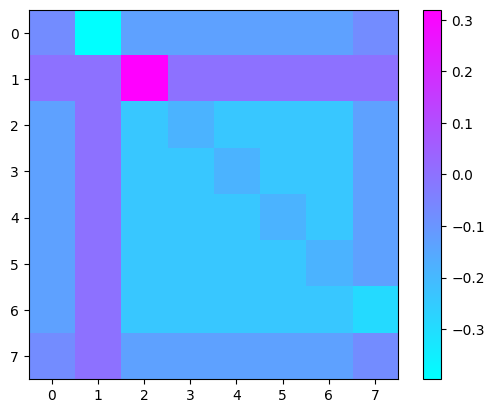

In [7]:
# get the QAOA Resukt object for the 2 step
q_result_2 = r.result.get_qaoa_results(step=2)
# get the QUBO problem for the 2 step
problem_2 = r.result.get_problem(step=2)

# getting information about the QAOA object and the QUBO problem
print('solution of the QAOA optimization in recursive step 2: ', q_result_2.most_probable_states)
print('terms of of the QUBO problem in recursive step 2: ', problem_2.terms)

#plotting the correlation matrix
fig, ax = r.result.plot_corr_matrix(step=2)
fig.show()

In [8]:
# Number of qubits
n_qubits = 10

# Define fully-connected terms
terms = [(i,j) for j in range(n_qubits) for i in range(j)]

# Assign weight signs at random
seed = 42
np.random.seed(seed)
weights = [(-1)**np.round(np.random.random()) for _ in range(len(terms))]

# Define QUBO problem
sk = QUBO(n_qubits,terms,weights)

In [9]:
# Obtain exact solution for comparison

# Define Hamiltonian object from terms and weights
hamiltonian = Hamiltonian.classical_hamiltonian(terms,weights,constant = 0)

# Compute the exact result
exact_energy, ground_state_strings = ground_state_hamiltonian(hamiltonian)

print(f'The exact energy is {exact_energy} and the solutions are {ground_state_strings}')

The exact energy is -17.0 and the solutions are ['1101100000', '1110011010', '0001100101', '0010011111']


In [10]:
# Define RQAOA instance
r =  RQAOA()

# Set parameters for adaptive RQAOA, the maximum number of eliminations allowed and final cutoff value
n_cutoff = 3
n_max = 3
r.set_rqaoa_parameters(n_cutoff = n_cutoff, n_max = n_max, rqaoa_type = 'adaptive')

# Compile problem instance on RQAOA
r.compile(sk)

# Solve problem with RQAOA
r.optimize()

# Extract results
result = r.result
solutions = result.get_solution()

states = list(solutions.keys())
energy = list(solutions.values())[0]

print(f'The solution found by Ada-RQAOA for nmax = {n_max} is energy = {energy} and ground states = {states}')

The solution found by Ada-RQAOA for nmax = 3 is energy = -17.0 and ground states = ['1101100000', '0010011111']


In [11]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from openqaoa.utilities import plot_graph, ground_state_hamiltonian
from openqaoa.backends import create_device
from openqaoa.problems import MinimumVertexCover
from openqaoa import QAOA

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

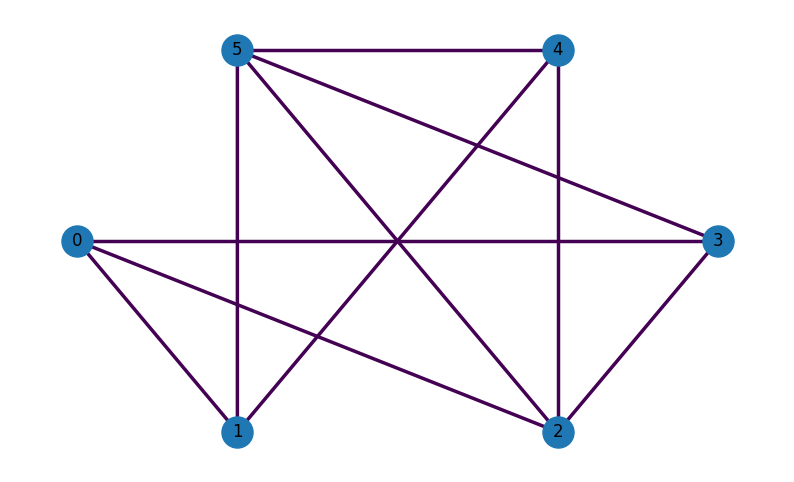

In [12]:
nodes = 6
edge_probability = 0.7
g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability, seed=34)
pos = nx.spring_layout(g)
plot_graph(g)

In [13]:
# Brute Force Solution
mini_cov = MinimumVertexCover(g, field = 1., penalty = 1.)
mini_cov_qubo = mini_cov.qubo
energy, configuration = ground_state_hamiltonian(mini_cov_qubo.hamiltonian)
print('Energy: {}'.format(energy), '\nConfigurations: {}'.format(configuration))

Energy: 4.0 
Configurations: ['011100', '011110', '101001', '011001', '111001', '011101', '100011', '101011', '100111']


/global/homes/g/gzquse/.local/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


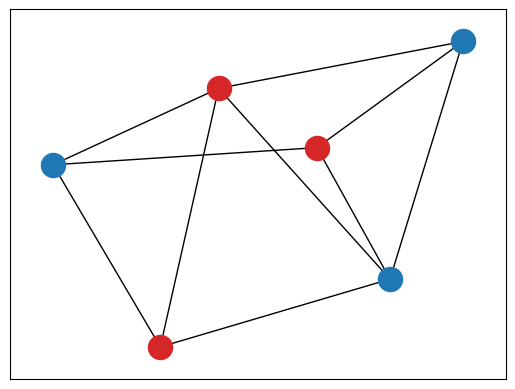

In [14]:
# Possible Solution (Red Nodes represents the Vertex Cover)
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)


In [15]:
q = QAOA()
q.set_circuit_properties(mixer_hamiltonian = 'x')
q.compile(mini_cov_qubo)

In [17]:
q.optimize()

In [18]:
q.result.most_probable_states

{'solutions_bitstrings': ['011110', '100111'], 'bitstring_energy': 4.0}

In [20]:
configuration = q.result.most_probable_states['solutions_bitstrings']

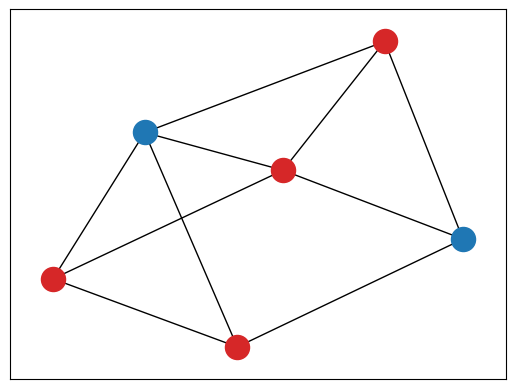

In [21]:
# Plotting the Vectorized Backend Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)


In [25]:
# You can specify a custom mixer block using the GateMap Objects
# Using manual mode
from openqaoa.qaoa_components.ansatz_constructor import RZXGateMap, RXXGateMap
from openqaoa.qaoa_components import QAOADescriptor, create_qaoa_variational_params
from openqaoa.backends import create_device
from openqaoa.optimizers import get_optimizer
from openqaoa.backends.qaoa_backend import get_qaoa_backend

custom_mixer_block_gatemap = [RZXGateMap(0, 1), RZXGateMap(0, 2),
                              RZXGateMap(0, 3), RZXGateMap(0, 4),
                              RZXGateMap(0, 5), RXXGateMap(1, 2)]
custom_mixer_block_coeffs = [1., 1., 1., 1., 1., 1.]

qaoa_descriptor = QAOADescriptor(mini_cov_qubo.hamiltonian,
                                   custom_mixer_block_gatemap, p=1,
                                   mixer_coeffs=custom_mixer_block_coeffs)
device_local = create_device(location='local', name='qiskit.statevector_simulator')
variate_params = create_qaoa_variational_params(qaoa_descriptor, 'standard', 'rand')
backend_local = get_qaoa_backend(qaoa_descriptor, device_local, n_shots=500)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla',
                                                          'maxiter': 100})

In [26]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAQiskitBackendStatevecSimulator 
Method: COBYLA with Max Iterations: 100

In [27]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['100111'], 'bitstring_energy': 4.0}

In [28]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

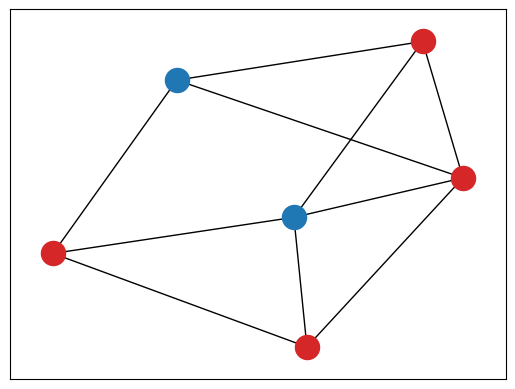

In [29]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

In [30]:
from openqaoa.utilities import quick_create_mixer_for_topology

# This function creates a star pattern mixer block with qubit 0 as its center
# If no coefficients are specified, the function uses default coefficients for
# all gatemaps in it
zx_gatemap_list, zx_gatemap_coeffs = quick_create_mixer_for_topology(RZXGateMap, 6, qubit_connectivity='star')
xx_gatemap_list, xx_gatemap_coeffs = quick_create_mixer_for_topology(RXXGateMap, 6, qubit_connectivity='full')

zx_gatemap_list.extend(xx_gatemap_list)
zx_gatemap_coeffs.extend(xx_gatemap_coeffs)

final_gatemap_list = zx_gatemap_list
final_gatemap_coeffs = zx_gatemap_coeffs

In [31]:
qaoa_descriptor = QAOADescriptor(mini_cov_qubo.hamiltonian,
                                   final_gatemap_list, p=1,
                                   mixer_coeffs=final_gatemap_coeffs)
device_local = create_device(location='local', name='vectorized')
variate_params = create_qaoa_variational_params(qaoa_descriptor, 'standard', 'rand')
backend_local = get_qaoa_backend(qaoa_descriptor, device_local)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla',
                                                          'maxiter': 100})

In [32]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 100

In [33]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['011111'], 'bitstring_energy': 5.0}

In [34]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

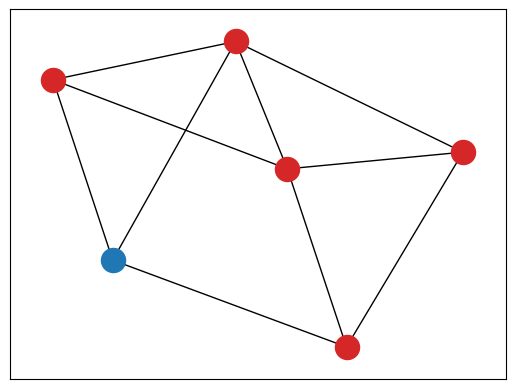

In [35]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

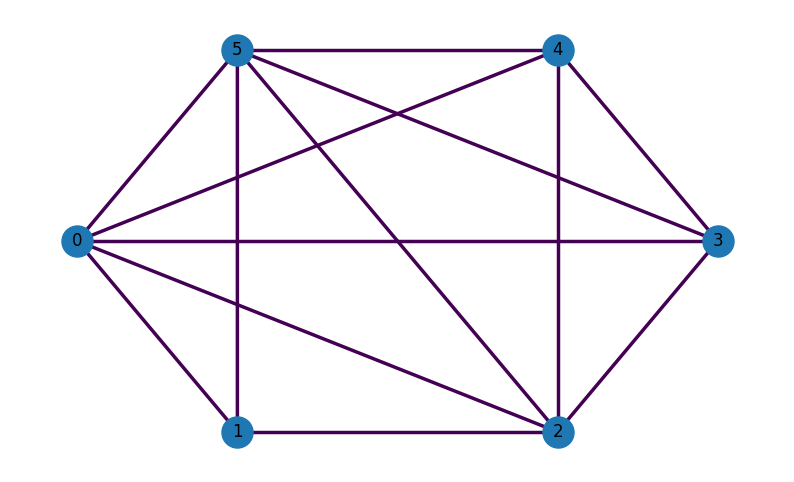

In [36]:
# Create 2-Qubit Connection Graph for Mixer
nodes = 6
edge_probability = 0.7
mixer_g = nx.generators.fast_gnp_random_graph(n=nodes,p=edge_probability, seed=42)
plot_graph(mixer_g)

In [37]:
# Input the EdgeMap into the convinience function
edge_map = [edge for edge in mixer_g.edges()]
edge_coeffs = [1.0]*len(edge_map)
final_gatemap_list, final_gatemap_coeffs = quick_create_mixer_for_topology(RXXGateMap, 6, edge_map, edge_coeffs)


In [38]:
qaoa_descriptor = QAOADescriptor(mini_cov_qubo.hamiltonian,
                                   final_gatemap_list, p=1,
                                   mixer_coeffs=final_gatemap_coeffs)
device_local = create_device(location='local', name='vectorized')
variate_params = create_qaoa_variational_params(qaoa_descriptor, 'standard', 'rand')
backend_local = get_qaoa_backend(qaoa_descriptor, device_local)
optimizer = get_optimizer(backend_local, variate_params, {'method': 'cobyla',
                                                          'maxiter': 100})

In [39]:
optimizer.optimize()

Optimizer for VQA of type: QAOABaseBackendStatevector 
Backend: QAOAvectorizedBackendSimulator 
Method: COBYLA with Max Iterations: 100

In [40]:
optimizer.qaoa_result.most_probable_states

{'solutions_bitstrings': ['101101'], 'bitstring_energy': 5.0}

In [41]:
configuration = optimizer.qaoa_result.most_probable_states['solutions_bitstrings']

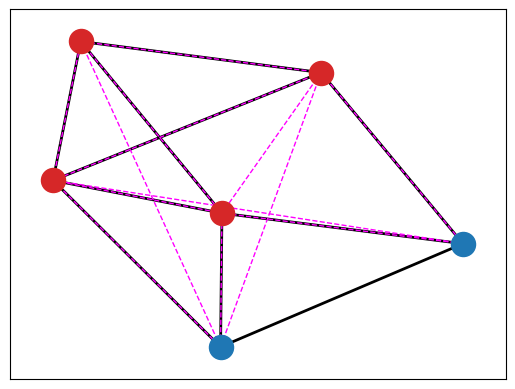

In [42]:
# Plotting the Solution
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos, width=2)
nx.draw_networkx_edges(mixer_g, pos, edge_color=(1, 0, 1), style="--")

In [43]:
from openqaoa.backends import create_device
device_azure = create_device(location='azure',
                             name='ionq.simulator',
                             resource_id='',
                             az_location='westus')